### **Introducción**




El siguiente ejemplo modifica el color de una imágen parametrizada, dando como resultado una nueva imagen con los colores diametralmente opuestos en el circulo cromatico). El cálculo de la Inversion de Color se realiza convirtiendo los 3 canales RGB, que representan a los colores R (rojo)-G(verde)-B(azul) de cada pixel, generando el complemento del valor de cada componente:
<center><br>$ Pixel= (255-R, 255-G, 255-B)$</center></br>

El objetivo del ejercicio es comparar y analizar la ejecucion en forma secuencial (usando solo CPU) y su version paralela (usando GPU).

---



### **Armado del ambiente**
Toma la direcciòn web de una imagen con acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

Obtencion de imagen

In [ ]:
### Parámetros de ejecución

#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://columnacero.com/pic/25689/spider-man-un-nuevo-universo.jpg" #@param {type:"string"}
#link a imagen de prueba https://columnacero.com/pic/25689/spider-man-un-nuevo-universo.jpg
# Leo la imagen desde internet y la almaceno "localmente" como imagen.jpg
!wget {url_imagen} -O imagen.jpg

--2021-11-24 12:25:44--  https://columnacero.com/pic/25689/spider-man-un-nuevo-universo.jpg
Resolving columnacero.com (columnacero.com)... 82.223.205.134
Connecting to columnacero.com (columnacero.com)|82.223.205.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190423 (186K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 185.96K   493KB/s    in 0.4s    

2021-11-24 12:25:46 (493 KB/s) - ‘imagen.jpg’ saved [190423/190423]



 Tener en cuenta que tambien es necesario instalar la libreria de la GPU como asi tambien verificar que este activo el entorno de ejecucion de GPU

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.6 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627661 sha256=f503714a6a4b53241d6c568d0b6ac2a50f1ea0c9ebfd51e7c200e455efff191d
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=cbf0f62a94744098cf652dfd4f6276a5182752923a302acffefe13f35b0d5686
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools




---



### **Desarrollo CPU**

Imagen: imagen.jpg -RGB- [1280, 720]
Tiempo de conversión de imagen: 11083.661 [ms]
Tiempo Total: 11217.98 [ms]


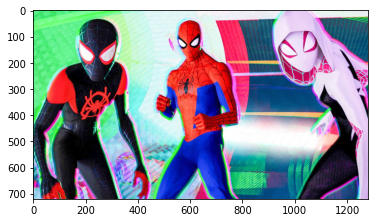

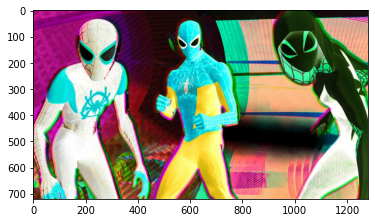

In [ ]:
 %matplotlib inline
from datetime import datetime

tiempo_total_cpu = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_cpu_nombre = 'imagen.jpg'
image = Image.open( img_cpu_nombre ) 
  
# Obtengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

#Convierto la imagen a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype(numpy.int32())

# Genero el array resultado mismo tamaño que el de la imagen original
img_picR_cpu = numpy.empty_like(img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen: " + img_cpu_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto) + "]" )  

plt.figure()
imgplot=plt.imshow(img_pic_cpu)

tiempo_img = datetime.now()

# Se realiza la inversion de color
for y  in range( 0, img_alto ): #(int)(img_alto/2)
  for x in range( 0, img_ancho ):
    pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]
    img_picR_cpu[y][x] = [255-pixel_R, 255-pixel_G, 255-pixel_B]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de la inversion del color.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total_cpu ), "[ms]" )



---




### **Desarrollo GPU**




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



Imagen: imagen.jpg -RGB- [1280, 720]
Thread: [ 16 , 10  ], Bloque : [ 80 , 72 ]
Total de Thread: [ 1280 , 720  ]  =  921600
Tiempo GPU  :  2.167 [ms]
Tiempo TOTAL:  1137.579 [ms]


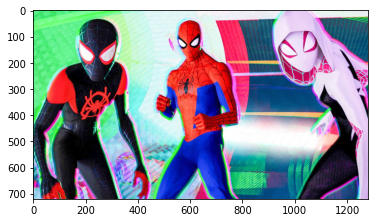

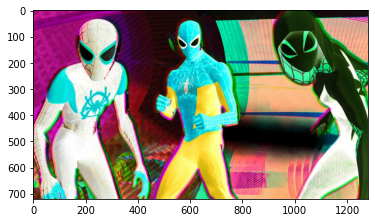

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_gpu_nombre = 'imagen.jpg'
image = Image.open( img_gpu_nombre ) 
  
# Obtengo las proporciones de la imagen. 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
#+ (int)(alto/2) en int idy
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  int red=0;
  int green=0;
  int blue=0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    //calculo el valor de cada pixel
    red=255-(img_O[(idx+(idy*ancho))*3  ]);// Componente Rojo del pixel.
    green=255-(img_O[((idx+(idy*ancho))*3)+1]);// Componente Verde del pixel.
    blue=255-(img_O[((idx+(idy*ancho))*3)+2]);// Componente Azul del pixel.

    //escribo el color de cada pixel.
    img_R[(idx+(idy*ancho))*3  ] = red;
    img_R[((idx+(idy*ancho))*3)+1] = green;
    img_R[((idx+(idy*ancho))*3)+2] = blue;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del filtro.
print("Imagen: " + img_gpu_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 10
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=(dim_hilo_x,dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) ) 

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total_gpu = datetime.now() - tiempo_total_gpu

print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )
print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total_gpu ), "[ms]" )

### **Metricas**




In [ ]:
### **Metricas**

print("CPU=")
print("Imagen del filtro: " + img_cpu_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto) + "]" )  
print( "Tiempo Total de CPU:",                   tiempo_en_ms( tiempo_total_cpu ), "[ms]" )

print("")
print("vs")
print("")

print("GPU=")
print("Imagen del filtro: " + img_gpu_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  
print("Tiempo GPU  : ",                          tiempo_en_ms( tiempo_img ),       "[ms]" )
print( "Tiempo Total de GPU:",                   tiempo_en_ms( tiempo_total_gpu ), "[ms]" )

CPU=
Imagen del filtro: imagen.jpg -RGB- [1280, 720]
Tiempo Total de CPU: 11217.98 [ms]

vs

GPU=
Imagen del filtro: imagen.jpg -RGB- [1280, 720]
Tiempo GPU  :  2.167 [ms]
Tiempo Total de GPU: 1137.579 [ms]


### Conclusiones
El tiempo de procesamiento de la imagen cuando se ejecuta el Algoritmo de forma paralela (es decir con la GPU) es considerablemente menor que si se realiza de forma secuencial (con la CPU). 
Para este tipo de proyectos, donde para una gran cantidad de datos se realiza el mismo calculo repetidamente, es muy recomendable resolverlo con GPU ya que se trata de tareas que pueden ser paralelizables.

### Bibliografia
Ing. Waldo Valiente. 27 Jun 2021. [Online]. Avaliable: [Ejercicio CPU "Escala de grises" provisto por la catedra](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb)                   
Ing. Waldo Valiente. 27 Jun 2021. [Online]. Avaliable: [Ejercicio GPU "Escala de grises" provisto por la catedra](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb)         
Algoritmo de inversion de color de imagen OpenCV. Anonimo. [Online]. Avaliable: https://programmerclick.com/article/1612326767/